[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/porterjenkins/byu-cs474/blob/master/lab3_cross_entropy_convnets.ipynb)

# Deep Learning Part 3: Datasets, Data Loading, Cross Entropy, and Convolutional Networks

## Grading Standards:
*  10%: Dataset/MNIST section
*  10%: Correct implementation and use of cross entropy loss
*  20%: Correct training/validation functions
*  40%: Successful training and validation with MLP and convolution networks
*  12%: Convolutional layer quiz
*   8%: Comparison between MLP and convolution networks
___


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

Set your global variable `device`, using the `torch.device()` function. In order to use cuda remember to request a GPU from Runtime > Change Runtime.

***Important Note**: If you spend too much time or memory on the GPU in Google Colab then you will be timed out. This may not be a big deal with this lab, but it can become a big deal in later labs. It is recommended to set your `device` and Runtime to CPU first and once everything in the lab is working properly to set it to the GPU.*

In [2]:
device = torch.device("cuda")

---

# Datasets and Data Loading



In [3]:
from torch.utils.data import Dataset, DataLoader

We are going to make a PyTorch `Dataset`.
There are three parts to creating a `Dataset`:
1. `__init__()`: This is where you get all relevant data for your dataset.
2. `__len__()`: You return how large your dataset is.
3. `__getitem__()`: You return an item from your dataset given an index.

Implement the TODOs below.

In [4]:
class SineDataset(Dataset):
    def __init__(self):
        # TODO: The code is same from lab 2, so you can uncomment the code below.
        self.x = torch.rand((100,1))*8 - 4
        self.y = torch.sin(self.x) + torch.randn_like(self.x)*.1 # the second part of the sum adds noise to the function

    def __len__(self):
        # TODO: Return the len of your dataset.
        return len(self.x)

    def __getitem__(self, i):
        # TODO: i will be an index so return x_i and y_i
        return self.x[i], self.y[i]

Now create a `SineDataset` and print out the length of dataset, i.e. `len(dataset)`, and the item in your dataset at index 0, i.e. `dataset[0]`.

In [5]:
dataset = SineDataset()
print(len(dataset))
print(dataset[0])

100
(tensor([-2.8411]), tensor([-0.2510]))


A `DataLoader` uses the `__len__` and `__getitem__` of a `Dataset` to sample indices in `[0, ..., len(dataset)-1]` and collect a batch of items from the `Dataset`.
The `DataLoader` will then try to convert the sampled entries into tensors (if they are not already) and concatenate them together.
Create a `DataLoader` object below; pass in your dataset and `batch_size=32` as arguments.

In [6]:
dataloader = DataLoader(dataset, batch_size=32)

Iterate through your dataloader with a for loop. Because `SineDataset.__getitem__()` returns two items, the for loop will return a tuple.
Either unpack the entries in your tuple in the for loop:
```python
for x, y in dataloader
```
or after the loop:
```python
for batch in dataloader:
    x, y = batch
```

Print out the shapes of `x` and `y` for each batch in the dataloader.

In [7]:
for x, y in dataloader:
    print(x.shape, y.shape)

torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([32, 1]) torch.Size([32, 1])
torch.Size([4, 1]) torch.Size([4, 1])


You will notice that the shapes are `(B, Z_in)`, where `B` is batch size and `Z_in` is our input feature size, which is exactly what we want.
Also note that the last batch has a batch size of 4; this is because the `DataLoader` samples **without replacement** and these are the last items in our `Dataset` that have not been sampled.

Let's now create our real dataset.

---

# MNIST

We are now going to look at the MNIST dataset, which is a dataset of handwritten numbers.
Our objective will be to create a neural network that can predict the number given the image.

First import `torchvision` below so we can retrieve the MNIST dataset.

In [8]:
import torchvision

You can use `torchvision.datasets.MNIST()` to download the MNIST dataset (which inherits the `Dataset` class).
For arguments, specify `root="/tmp/"` to denote the location, `train=True` or `train=False` to get the training or test dataset, `download=True` to specify you want to download the dataset, and `transform=torchvision.transforms.ToTensor()` to convert the MNIST images from PIL images to PyTorch tensors.
Create both a `train_dataset` and `val_dataset`.

*Note: It is good practice to use a train, val, and test dataset, especially in the real world, but in this class we will mainly focus on train and val datasets to simplify things.*

In [9]:
train_dataset = torchvision.datasets.MNIST(root="/tmp/", train=True, download=True, transform=torchvision.transforms.ToTensor())
val_dataset = torchvision.datasets.MNIST(root="/tmp/", train=False, download=True, transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17587940.84it/s]


Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 480567.52it/s]


Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4418515.50it/s]


Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4351422.74it/s]

Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/raw



Print out the lengths of `train_dataset` and `val_dataset`.

In [10]:
print(len(train_dataset))
print(len(val_dataset))

60000
10000


Grab element 0 from the `train_dataset`. As a heads up, like our `SineDataset`, `MNIST` returns an image `x` and a class/target `y`.

In [11]:
x_0, y_0 = train_dataset[0]

Use the `type()` function to see what type of object `x` and `y` are.

In [12]:
print(type(x_0))
print(type(y_0))

<class 'torch.Tensor'>
<class 'int'>


Since x is a tensor, print out its `.dtype`, `.shape`

In [13]:
print(x_0.dtype)
print(x_0.shape)

torch.float32
torch.Size([1, 28, 28])


The shape of a tensor image is `(C, H, W)`, where `C` is channels, `H` is height, and `W` is width.
In our case `x` has 1 channel and it is a 28x28 image.
Because there is 1 channel, it is likely that the image is grayscale (which it is).

Now visualize the image and display its class.
Use the `plt.imshow()` function to visualize `x`; add the argument `cmap="gray"` to denote the image is grayscale.
Use the `plt.title()` function to set the title of the `plt` image to the class `y`.

*Note: `plt` expects grayscale images to only have to dimension, HxW, so `.squeeze()` the 0th dimension*

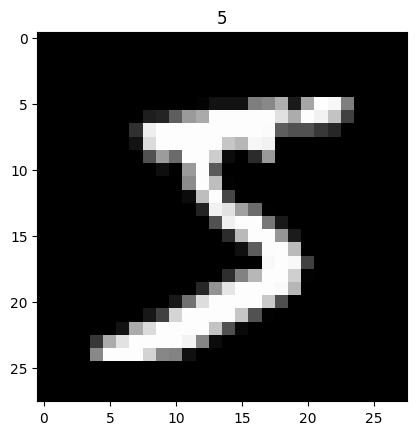

In [14]:
plt.imshow(x_0.squeeze(0), cmap="gray")
plt.title(y_0)
plt.show()

Print out the min and max values of `x` using `torch.min()` and `torch.max()`.

In [15]:
print(torch.min(x_0))
print(torch.max(x_0))

tensor(0.)
tensor(1.)


Our tensors are normalized between 0 and 1, which is good so we don't have to do any normalization.
Now that we have a better understanding of our image data, let's examine the classes in the dataset.

Create a `get_dataset_classes()` function which takes a dataset as input and count how many times each class appears.
Return a dictionary where the keys are the classes and the values represent the number of times each class appears in the dataset.

In [16]:
def get_dataset_classes(dataset):
    classes = {}
    for _, y in dataset:
        if y not in classes:
            classes[y] = 0
        classes[y] += 1
    return classes

Execute the code below to visualize the dataset classes.

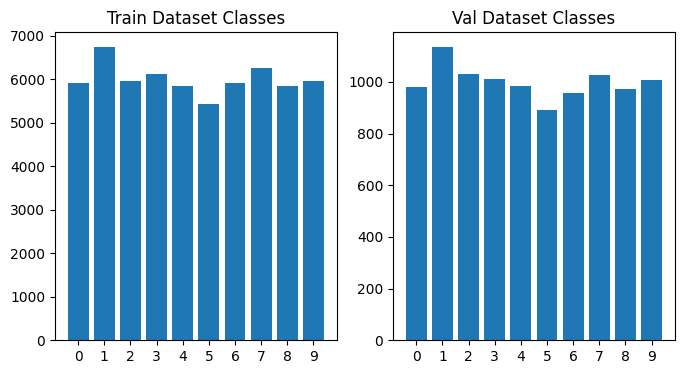

In [17]:
train_classes = get_dataset_classes(train_dataset)
val_classes = get_dataset_classes(val_dataset)

def plot_classes(ax, classes, title):
    ax.bar(classes.keys(), classes.values())
    ax.set_title(title)
    ax.set_xticks(list(range(10)))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
plot_classes(axes[0], train_classes, "Train Dataset Classes")
plot_classes(axes[1], val_classes, "Val Dataset Classes")
plt.show()

There are 10 classes, which makes sense because there are 10 digits, 0-9.
Furthermore, the classes are pretty evenly spread on both datasets, which means our baseline accuracy is roughly 10%.

Now create two `DataLoader` objects called, `train_loader` and `val_loader`.
The `train_loader` should have your `train_dataset` and the `val_loader` should have your `val_dataset`.
Set the `batch_size` of both dataloaders equal to 32 and set `shuffle=True` for the `train_loader` so that the dataset is shuffled every time.
To improve the speed at which you `DataLoader`s can load the data, set `num_workers=4` (for multiprocessing).

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Now use `x, y = next(iter(train_loader))` to get a single batch of data from the `train_loader` and print out the shapes and dtypes of `x` and `y`

In [19]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)
print(x.dtype)
print(y.dtype)

torch.Size([32, 1, 28, 28])
torch.Size([32])
torch.float32
torch.int64


The shape of `x` is `(B, C, H, W)`, where `B` is the batch size. **Always remember, in PyTorch, your data should have a batch dimension.**
The shape of `y` is `(B,)` and it is a tensor of type `long`, which is what we want because we are doing classification, which means we want our target to be a class label.

___

### MLP Network

We are now going to make our network.
Because we are doing image classification, the input to our network is a batch of images, `shape=(B, C, H, W)`, and the output of our network is a batch of probabilities, `shape=(B, K)`, where `K` represents the number classes in our dataset.
In our case `K=10`.

We will first try to solve this problem using a fully connected deep network (like your DeepNet from lab 2), sometimes called a Multi-Layer Perceptron (MLP).  
Implement an `MLP` below (don't forget to use `nn.Sequential`, `nn.Linear`, `nn.ReLU`).
Because `nn.Linear` expects tensors of shape `(B, Z)`, where `Z` is the input feature size, we need to flatten our images. Use the `.view()` function to reshape `x.shape=(B, C, H, W)` into `x.shape=(B, Z)`, where `Z=C*H*W`.  

In [20]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_size):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_features)
        )


    def forward(self, x):
        return self.network(x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))

Because we are doing classification, we need to use a different loss function that MSE; cross entropy loss is a good choice and is a common loss function for classification.

---

# Softmax and CrossEntropy

The cross entropy (CE) function is $CE(p, q) = - \sum p(x) \log q(x)$, where $p$ and $q$ are probability functions ($p$ is the target probabilities and $q$ is the predicted probabilities) and in our case $x$ represents a class.

$p$ represents the target distribution, the true class distribution, which means it is a one-hot vector $p_c$, where $c$ represents the index of the class:
$$p_i = \begin{cases}
1, & \textrm{if } i = c \\
0, & \textrm{if } i \not = c \\
\end{cases}$$

Then $CE(p, q) = - \sum_i p_i \log q_i$ will become $CE(p, q) = - p_c \log q_c$, because $p_{i \not = c} = 0$, which is further reduced to $CE(p, q) = - \log q_c$, since $p_c = 1$. In other words, cross entropy loss for classification is the negative log of the predicted probability of the correct class.

Therefore, $p$ is never passed into `F.cross_entropy_loss()`, instead you pass in $q$ you predicted distribution and $c$ the index of the correct class.

Implement `prenormalized_cross_entropy_loss` below. $q$ is assumed to be a normalized probability distribution.

*Note: Do **not** use a for loop. You can index into a tensor with array slicing (hint: You will need to use `torch.arange()` for the 0th dimension of `q`)*

In [21]:
def prenormalized_cross_entropy_loss(q, c):
    return -np.log(q[torch.arange(len(q)), c]).mean()

Validate your function below.

In [22]:
def test_prenormalized_cross_entropy_loss():
    q = torch.tensor([[.1, .5, .4],
                      [.2, .2, .6],
                      [.3, .3, .3]])
    c = torch.tensor([2, 0, 1])
    assert torch.allclose(prenormalized_cross_entropy_loss(q, c), torch.tensor(1.2432), atol=1e-4)

test_prenormalized_cross_entropy_loss()

This assumed that `q` was a probability distribution, but usually neural networks output logits $l$, which are unnormalized probabilities.
One way we could normalize our logits $l$ into probabilities $q$ is to divide $l$ by the sum of logits $q_i = \frac{l_i}{\sum_j l_j}$, but that doesn't work if $l_i$ is negative.
The softmax, which exponentiates the $logit$, $q_i = \frac{e^{l_i}}{\sum_j e^{l_j}}$, before dividing by the sum of exponentiated logits removes the issues of negativity (there are other good reasons for using softmax, such as numerical stability).

However, applying `q = softmax(l)` to `prenormalized_cross_entropy_loss(q, c)` can still be numerically unstable.
Luckily, we can simplify our function:
$$\begin{align}
CE(l, c) &= - \log \frac{e^{l_c}}{\sum_j e^{l_j}} \\
&= - (\log e^{l_c} - \log \sum_j e^{l_j}) \\
&= - (l_c - \log \sum_j e^{l_j}) \\
&= - l_c + \log \sum_j e^{l_j}
\end{align}$$

While you could implement $\log \sum_j e^{l_j}$, you should use `torch.logsumexp()` which will exponentiate, sum, and then log your logits, but in a more numerically stable way.
Implement `cross_entropy_loss()` below.
You can validate it works by comparing it with the output of `F.cross_entropy()`.

*Note: Do **not** use a for loop*

In [23]:
def cross_entropy_loss(l, c):
    return (-l[torch.arange(len(l)), c] + torch.logsumexp(l, dim=1)).mean()

def test_cross_entropy_loss():
    q = torch.tensor([[.1, .5, .4, .0],
                      [.2, .2, .6, .9],
                      [.3, .3, .3, .3]])
    c = torch.tensor([2, 0, 1])

    print(cross_entropy_loss(torch.log(q), c))
    print(F.cross_entropy(torch.log(q), c))

test_cross_entropy_loss()

tensor(1.5180)
tensor(1.5180)


It is hard to tell how well a model is performing just from its cross entropy loss, so create a `get_accuracy()` function to measure accuracy.
`get_accuracy()` takes in a `y_hat` and `y`, where `y_hat` contains the predicted logits (unnormalized probabilities) for some images `x` and `y` are the labels.
You can get the predicted label from `y_hat`, by using the `torch.argmax()` function.

*Note: Do **not** use a for loop.*

In [24]:
def get_accuracy(y_hat, y):
    y_prediction = torch.argmax(y_hat, dim=1)
    return (y_prediction == y).float().mean()

## Validation and Training


To see how well training is going, implement a `validation()` function to compute the average loss and accuracy over all instances in the `val_loader`.
This function will look very similar to a basic training loop, but without any optimization, e.g. no `loss.backward()` or `optimizer.step()`.
To speed up the process use `torch.no_grad()` to keep PyTorch from building the computation graph.
You can use `torch.no_grad()` either as a decorator:
```python
@torch.no_grad()
def fn():
    ...
```
or as a context manager:
```python
def fn():
    with torch.no_grad():
        ...
```

*Remember you can use `.item()` on a tensor with one element to convert it into a float/int.*

In [25]:
@torch.no_grad()
def validation(net, val_loader):
    # TODO: Return the network's average loss and accuracy on the val loader
    net = net.to(device)

    x, y = next(iter(val_loader))
    x = x.to(device)
    y = y.to(device)

    y_hat = net(x)
    loss = cross_entropy_loss(y_hat, y)
    accuracy = get_accuracy(y_hat, y)

    return loss, accuracy

Now implement the `train()` function.
This will look similar to the `train()` you implemented in lab 2, but now you will also store training accuracies, and at every `log_val_interval` you will call `validation` and store the validation loss and accuracy.

In [26]:
def train(net, train_loader, val_loader, optimizer, n_optimization_steps, log_val_interval):
    # TODO: Implement training loop and return the training and validation losses and accuracies.
    net = net.to(device)

    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []

    for i in range(n_optimization_steps):
        x, y = next(iter(train_loader))
        x = x.to(device)
        y = y.to(device)

        y_hat = net(x)
        loss = cross_entropy_loss(y_hat, y)
        accuracy = get_accuracy(y_hat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

        if i % log_val_interval == 0:
            val_loss, val_accuracy = validation(net, val_loader)
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy.item())

    return losses, accuracies, val_losses, val_accuracies

Now train an `MLP` on `MNIST`. To speed up training use the `torch.optim.Adam` optimizer instead of `torch.optim.SGD`.

*Note: Don't forget to put your network on `device`.*

In [27]:
# TODO: Set torch seed for reproducibility
torch.manual_seed(0)

# TODO: Initialize your MLP, called net
net = MLP(28 * 28, 10, 128)
net.to(device)

# TODO: Create an Adam optimizer (lr=.001 works well)
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

# TODO: Train your MLP for 2000 steps and set log_val_interval=50
losses, accuracies, val_losses, val_accuracies = train(
    net, train_loader, val_loader, optimizer, 2000, 50
)

Now plot your training and validation loss on the same plot and plot your training and validation accuracies on the same plot.
Properly set your x- and y-axis labels and create a legend to make your plot legible.  

*Note: that you can specify the x-values for each point by calling `plt.plot(x, y)` instead of `plt.plot(y)`. Since you store validation every 50 steps, you'll need to use `torch.arange` to get the proper x-values to align the validation results to the training results.*

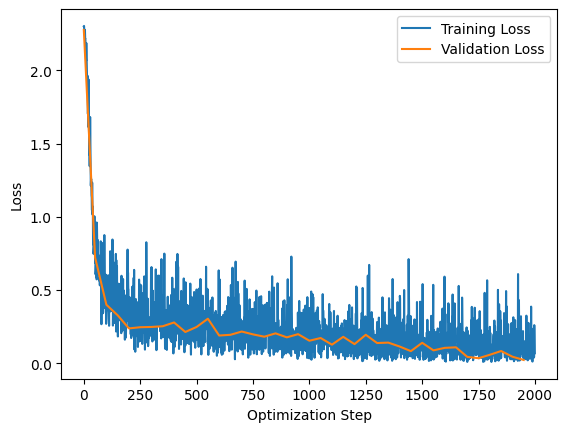

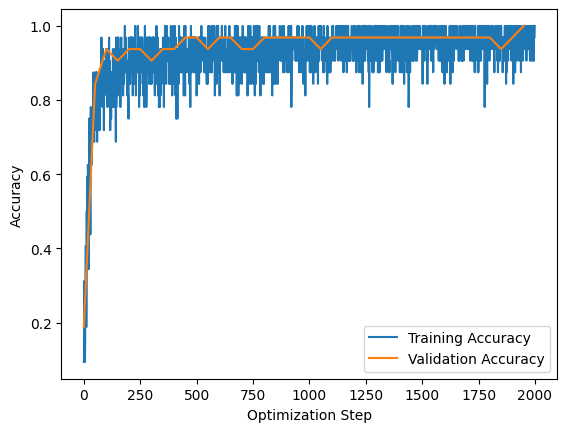

In [33]:
train_steps = len(losses)
val_steps = torch.arange(0, train_steps, 50)

plt.plot(losses, label="Training Loss")
plt.plot(val_steps, val_losses, label="Validation Loss")
plt.xlabel("Optimization Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(accuracies, label="Training Accuracy")
plt.plot(val_steps, val_accuracies, label="Validation Accuracy")
plt.xlabel("Optimization Step")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

___

# Convolution Networks

Now we will create a convolution network.
When we were dealing with an `MLP` we used fully-connected `nn.Linear` layers.
In a convolution network we use `nn.Conv2d` layers.
`nn.Linear` maps tensors of shape `(B, F_in) -> (B, F_out)`.
`nn.Conv2d` maps tensors of shape `(B, C_in, H_in, W_in) -> (B, C_out, H_out, W_out)`, where `C_in` represents our input channels and `C_out` represents our output channels.
You decide what `C_out` should be when you initialize.
The mapping that

If we had a batch of `img` tensors with shape `(B, 3, 8, 8)` and we wanted it to become `(B, 6, 4, 4)` we could create a convolution layer:
```python
conv_layer = nn.Conv2d(in_channels=3,  # Our 'C_in' which is 3
                       out_channels=6, # Our desired 'C_out'
                       kernel_size=2,  # One way to make an 8x8 image become a 2x2 image is to have the kernel be 2x2,
                       padding=0,      #    with zero padding,
                       stride=2,       #    and a stride of 2.
                      )
```
Validate this is true below by creating `conv_prac()` function, which creates a random tensor with shape `(B, 3, 8, 8)`, passes it through `conv_layer`, and prints out the resulting shape.

*Note: `kernel_size`, `padding`, and `stride` can all be tuples in case you want different (height, width) parameters, e.g. `kernel=(kernel_height, kernel_width)`.*

In [ ]:
def conv_prac():
    pass

conv_prac()

___

### Quiz
Test your knowledge of how convolution layers affect the shape of outputs by answering the following quiz questions.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(3, 3), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **Your answer in bold here**

*Using a Kernel size of 5×5:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **Your answer in bold here**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **Your answer in bold here**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **Your answer in bold here**




## ConvNet

Now create a convolution network `ConvNet` that inherits `nn.Module`.
The network should have 3 convolution layers (each layer should have 16 output channels):
1. Conv Layer 1 should have a 6x6 kernel, no padding, and a stride of 2.
2. Conv Layer 2 should have a 4x4 kernel, no padding, and a stride of 2.
3. Conv Layer 3 should have a 3x3 kernel, no padding, and a stride of 1.

The output of these layers should be a 3x3 image with 16 channels.
You should flatten the image (you can use `.view()`, `torch.flatten()`, or `nn.Flatten()`) and then pass it through 2 linear layers:
1. Linear Layer 1 should take the flattened image and map it to a vector with 16 features.
2. Linear Layer 2 should map its vector to logits.

Do not forget to add nonlinearities between the layers (do not add them to the last layer).

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, ):
        pass

    def forward(self, x):
        pass

Train you convolution network below.

In [ ]:
# TODO: Set seed for reproducibility

# TODO: Initalize your ConvNet, called 'conv_net'
conv_net = None

# TODO: Create an Adam optimizer (lr=.001 works well)

# TODO: Train your ConvNet for 2000 steps and set log_val_interval=50


Now plot your training and validation loss on the same plot and plot your training and validation accuracies on the same plot.

Create a function that outputs the number of parameters in a network.
Remember you can call `.parameters()` to recursively retrieve the `Parameter`s in a `Module`.
You could then use `.shape` to figure out the number of parameters in a `Parameter` or you could flatten the parameter and get its length.

In [ ]:
def get_n_net_params(net):
    pass

Print the number of parameters and the accuracy of your trained `MLP` and `ConvNet` networks and then write down below:
- Which one is more accurate?
- Which one is smaller?

*Note: You can use `validation()` to get the accuracy of your network.*